# 2D Eye-Tracking Camera Views

This notebook demonstrates 2D camera views of the eyes as seen by the eye-tracking cameras, showing pupils, corneal reflections, glints, limbus, and eyelid boundaries.

## Imports and Setup

In [176]:
%matplotlib widget

import seet.device as device
import seet.scene as scene
import seet.user as user
import seet.visualization.scene_visualization as scene_visualization
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import sys
sys.path.append("..")
import utils

dropdown_widget = utils.get_experiment_info(save_results=False)

RadioButtons(description='Device:', options=('default',), value='default')

## Create Scene Model

In [177]:
# Create a scene
scene_file_name, _ = \
    utils.get_configuration_files(dropdown_widget.value)  # type: ignore

et_scene = scene.SceneModel(parameter_file_name=scene_file_name)

print(f"Scene loaded from: {scene_file_name}")
print(f"Number of eyes: {len(et_scene.user.eyes)}")
print(f"Number of subsystems: {len(et_scene.device.subsystems)}")

Scene loaded from: C:\Users\padossa\repos\seet-1\seet\scene\default_scene/default_scene.json
Number of eyes: 2
Number of subsystems: 2


## 2D Camera Views

Display the eyes as observed by the eye-tracking cameras, similar to what the actual cameras would see.

Generating figure: 15° Upward Gaze


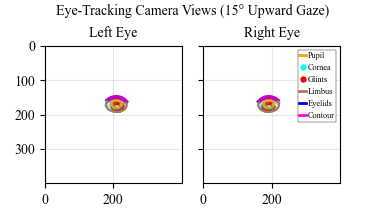

Saved: gaze_up_15deg_252pt.pdf
Final figure width will be 252pt after tight bounding box

Generating figure: 15° Downward Gaze


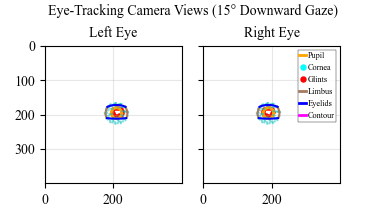

Saved: gaze_down_15deg_252pt.pdf
Final figure width will be 252pt after tight bounding box

Generating figure: 20° Rightward Gaze


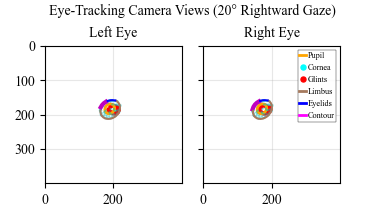

Saved: gaze_right_20deg_252pt.pdf
Final figure width will be 252pt after tight bounding box

All three figures generated and saved as PDF files:
- gaze_up_15deg_252pt.pdf (15° Upward Gaze)
- gaze_down_15deg_252pt.pdf (15° Downward Gaze)
- gaze_right_20deg_252pt.pdf (20° Rightward Gaze)


In [178]:
# Set Times New Roman font globally at 10pt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10

# Setup for 2D camera views
subsystem_index = 0
camera_index = 0

subsystem = et_scene.device.subsystems[subsystem_index]
camera = subsystem.cameras[camera_index]
resolution = camera.resolution.clone().detach().numpy()

# Define gaze conditions
gaze_conditions = [
    {"angles": torch.tensor((0.0, -15.0)), "name": "gaze_up_15deg", "title": "15° Upward Gaze"},
    {"angles": torch.tensor((0.0, 15.0)), "name": "gaze_down_15deg", "title": "15° Downward Gaze"},
    {"angles": torch.tensor((-20.0, 0.0)), "name": "gaze_right_20deg", "title": "20° Rightward Gaze"}
]

# Generate and save all three figures
for condition in gaze_conditions:
    print(f"Generating figure: {condition['title']}")
    
    # Calculate figure size for exactly 252pt width (final size after tight bbox)
    # Start with larger size to ensure 252pt final width after cropping
    # Use a moderate aspect ratio to make subplots bigger but not too big
    fig_width_pt = 252 * 1.1  # Start 10% larger to account for tight bbox cropping
    fig_height_pt = fig_width_pt / 1.85  # Changed to 1.85:1 ratio for slightly smaller subplots
    fig_width_in = fig_width_pt / 72  # Convert to inches
    fig_height_in = fig_height_pt / 72

    # Create subplot with 2 panels: Left Eye, Right Eye
    fig_2d, axs_2d = plt.subplots(nrows=1, ncols=2, figsize=(fig_width_in, fig_height_in))
    fig_2d.suptitle(f"Eye-Tracking Camera Views ({condition['title']})", fontsize=10)

    # Use aggressive manual spacing control - remove the conflicting subplots_adjust
    # and apply very tight spacing after all plotting is done

    # Store legend information
    legend_elements = []
    legend_labels = []

    # Use the gaze angles from the current condition
    angles_deg = condition['angles']

    # Visualize each eye and extract actual colors/styles
    for i in range(2):
        eye = et_scene.user.eyes[i]
        eye.rotate_from_gaze_angles_inParent(angles_deg)

        ax = axs_2d[i]  # Direct mapping: 0=left, 1=right
        ax.set_title(f"{'Left' if i == 0 else 'Right'} Eye", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=10)
        
        # Invert Y-axis so it increases from top to bottom (image coordinates)
        ax.invert_yaxis()
        
        # Remove y-axis labels from right subplot to save space
        if i == 1:  # Right eye subplot
            ax.tick_params(labelleft=False)
            ax.set_ylabel('')
        
        # Create image visualization for this subsystem
        et_image_visualization = \
            scene_visualization.ImageVisualization(
                et_scene, ax, subsystem_index=i
            )

        # Visualize different eye features
        et_image_visualization.visualize_refracted_pupil()
        et_image_visualization.visualize_cornea()
        et_image_visualization.visualize_glints()
        et_image_visualization.visualize_limbus()
        et_image_visualization.visualize_eyelids()
        
        # Extract legend elements only from the first eye to avoid duplicates
        if i == 0:
            # Get actual colors from the plotted elements by examining the axes children
            plotted_elements = ax.get_children()
            
            # Pupil - orange curve (Line2D objects)
            pupil_color = 'orange'  # Default, will be updated if found
            for element in plotted_elements:
                if hasattr(element, 'get_color') and hasattr(element, 'get_linestyle'):
                    color = element.get_color()
                    if isinstance(color, str) and ('orange' in color.lower() or color.startswith('#ff') or color.startswith('#f')):
                        pupil_color = color
                        break
            legend_elements.append(plt.Line2D([0], [0], color=pupil_color, linewidth=2))
            legend_labels.append('Pupil')
            
            # Cornea - cyan dots (scatter plot or Line2D with markers)
            cornea_color = 'cyan'  # Based on your description
            for element in plotted_elements:
                if hasattr(element, 'get_facecolor') or hasattr(element, 'get_color'):
                    if hasattr(element, 'get_facecolor'):
                        colors = element.get_facecolor()
                        if hasattr(colors, '__len__') and len(colors) > 0:
                            color = colors[0] if hasattr(colors[0], '__len__') else colors
                            # Check if it's cyan-ish
                            if isinstance(color, (list, tuple, np.ndarray)) and len(color) >= 3:
                                if color[0] < 0.5 and color[1] > 0.5 and color[2] > 0.5:  # Cyan-ish RGB
                                    cornea_color = color
                                    break
            legend_elements.append(plt.Line2D([0], [0], marker='o', color=cornea_color, 
                                            linewidth=0, markersize=6))
            legend_labels.append('Cornea')
                
            # Glints - red dots
            glint_color = 'red'
            legend_elements.append(plt.Line2D([0], [0], marker='o', color=glint_color, 
                                            linewidth=0, markersize=6))
            legend_labels.append('Glints')
                
            # Limbus - brownish curve
            limbus_color = 'brown'  # Based on your description
            for element in plotted_elements:
                if hasattr(element, 'get_color') and hasattr(element, 'get_linestyle'):
                    color = element.get_color()
                    if isinstance(color, (list, tuple, np.ndarray)) and len(color) >= 3:
                        # Check if it's brownish (higher red, medium green, low blue)
                        if color[0] > 0.4 and color[1] > 0.2 and color[1] < 0.6 and color[2] < 0.4:
                            limbus_color = color
                            break
                    elif isinstance(color, str) and ('brown' in color.lower() or color.startswith('#8') or color.startswith('#a')):
                        limbus_color = color
                        break
            legend_elements.append(plt.Line2D([0], [0], color=limbus_color, linewidth=2))
            legend_labels.append('Limbus')
                
            # Eyelids - blue curve
            eyelids_color = 'blue'  # Based on your description
            for element in plotted_elements:
                if hasattr(element, 'get_color') and hasattr(element, 'get_linestyle'):
                    color = element.get_color()
                    if isinstance(color, (list, tuple, np.ndarray)) and len(color) >= 3:
                        # Check if it's blue (low red, low green, high blue)
                        if color[0] < 0.3 and color[1] < 0.3 and color[2] > 0.5:
                            eyelids_color = color
                            break
                    elif isinstance(color, str) and ('blue' in color.lower() or color == 'b'):
                        eyelids_color = color
                        break
            legend_elements.append(plt.Line2D([0], [0], color=eyelids_color, linewidth=2))
            legend_labels.append('Eyelids')
            
            # Contour - magenta curve
            contour_color = 'magenta'
            legend_elements.append(plt.Line2D([0], [0], color=contour_color, linewidth=2))
            legend_labels.append('Contour')

        # Reset eye rotation
        eye.unrotate_from_gaze_angles_inParent(angles_deg)

    # Add inset legend to the right subplot (top-right corner)
    if legend_elements:
        right_ax = axs_2d[1]  # Right eye subplot
        legend = right_ax.legend(legend_elements, legend_labels, 
                               loc='upper right', fontsize=6, frameon=True, 
                               fancybox=False, shadow=False, borderpad=0.2,
                               handlelength=0.8, handletextpad=0.2, columnspacing=0.3,
                               markerscale=0.6)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.9)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_linewidth(0.3)

    # Minimize ALL whitespace while adding a bit more space between subplots
    plt.subplots_adjust(left=0.02, right=0.98, top=0.78, bottom=0.12, wspace=-0.25)

    # Save as PDF with tight bounding box to achieve exactly 252pt width
    pdf_filename = f"{condition['name']}_252pt.pdf"
    fig_2d.savefig(pdf_filename, format='pdf', bbox_inches='tight', 
                   dpi=300, facecolor='white', edgecolor='none')
    
    plt.show()
    plt.close(fig_2d)  # Close to free memory
    
    print(f"Saved: {pdf_filename}")
    print(f"Final figure width will be 252pt after tight bounding box\n")

print("All three figures generated and saved as PDF files:")
for condition in gaze_conditions:
    print(f"- {condition['name']}_252pt.pdf ({condition['title']})")

Generating zoomed figure: 15° Upward Gaze (Zoomed)


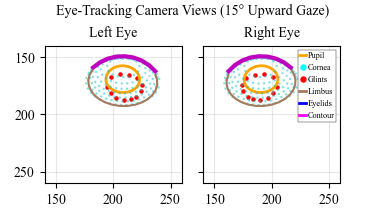

Saved: gaze_up_15deg_zoomed_252pt.pdf
Final figure width will be 252pt after tight bounding box

Generating zoomed figure: 15° Downward Gaze (Zoomed)


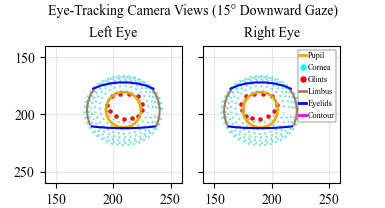

Saved: gaze_down_15deg_zoomed_252pt.pdf
Final figure width will be 252pt after tight bounding box

Generating zoomed figure: 20° Rightward Gaze (Zoomed)


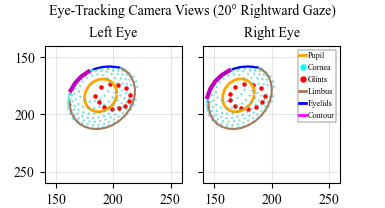

Saved: gaze_right_20deg_zoomed_252pt.pdf
Final figure width will be 252pt after tight bounding box

All three zoomed figures generated and saved as PDF files:
- gaze_up_15deg_zoomed_252pt.pdf (15° Upward Gaze (Zoomed))
- gaze_down_15deg_zoomed_252pt.pdf (15° Downward Gaze (Zoomed))
- gaze_right_20deg_zoomed_252pt.pdf (20° Rightward Gaze (Zoomed))


In [179]:
# Zoomed-in view of the eye region [100, 299] x [100, 299]
# Set Times New Roman font globally at 10pt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10

# Setup for 2D camera views
subsystem_index = 0
camera_index = 0

subsystem = et_scene.device.subsystems[subsystem_index]
camera = subsystem.cameras[camera_index]
resolution = camera.resolution.clone().detach().numpy()

# Define gaze conditions
gaze_conditions = [
    {"angles": torch.tensor((0.0, -15.0)), "name": "gaze_up_15deg_zoomed", "title": "15° Upward Gaze (Zoomed)"},
    {"angles": torch.tensor((0.0, 15.0)), "name": "gaze_down_15deg_zoomed", "title": "15° Downward Gaze (Zoomed)"},
    {"angles": torch.tensor((-20.0, 0.0)), "name": "gaze_right_20deg_zoomed", "title": "20° Rightward Gaze (Zoomed)"}
]

# Generate and save all three figures with zoomed view
for condition in gaze_conditions:
    print(f"Generating zoomed figure: {condition['title']}")
    
    # Calculate figure size for exactly 252pt width (final size after tight bbox)
    # Start with larger size to ensure 252pt final width after cropping
    # Use a moderate aspect ratio to make subplots bigger but not too big
    fig_width_pt = 252 * 1.1  # Start 10% larger to account for tight bbox cropping
    fig_height_pt = fig_width_pt / 1.85  # Changed to 1.85:1 ratio for slightly smaller subplots
    fig_width_in = fig_width_pt / 72  # Convert to inches
    fig_height_in = fig_height_pt / 72

    # Create subplot with 2 panels: Left Eye, Right Eye
    fig_2d, axs_2d = plt.subplots(nrows=1, ncols=2, figsize=(fig_width_in, fig_height_in))
    fig_2d.suptitle(f"Eye-Tracking Camera Views ({condition['title'].replace(' (Zoomed)', '')})", fontsize=10)

    # Use aggressive manual spacing control - remove the conflicting subplots_adjust
    # and apply very tight spacing after all plotting is done

    # Store legend information
    legend_elements = []
    legend_labels = []

    # Use the gaze angles from the current condition
    angles_deg = condition['angles']

    # Visualize each eye and extract actual colors/styles
    for i in range(2):
        eye = et_scene.user.eyes[i]
        eye.rotate_from_gaze_angles_inParent(angles_deg)

        ax = axs_2d[i]  # Direct mapping: 0=left, 1=right
        ax.set_title(f"{'Left' if i == 0 else 'Right'} Eye", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=10)
        
        # Invert Y-axis so it increases from top to bottom (image coordinates)
        ax.invert_yaxis()
        
        # Remove y-axis labels from right subplot to save space
        if i == 1:  # Right eye subplot
            ax.tick_params(labelleft=False)
            ax.set_ylabel('')
        
        # Create image visualization for this subsystem
        et_image_visualization = \
            scene_visualization.ImageVisualization(
                et_scene, ax, subsystem_index=i
            )

        # Visualize different eye features
        et_image_visualization.visualize_refracted_pupil()
        et_image_visualization.visualize_cornea()
        et_image_visualization.visualize_glints()
        et_image_visualization.visualize_limbus()
        et_image_visualization.visualize_eyelids()
        
        # Crop to 120x120 region in the center of the image
        # Calculate center crop coordinates
        center_x = resolution[0] / 2  # Center X coordinate
        center_y = resolution[1] / 2  # Center Y coordinate
        crop_size = 60  # Half of 120x120
        
        x_min = center_x - crop_size
        x_max = center_x + crop_size
        y_min = center_y - crop_size
        y_max = center_y + crop_size
        
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        
        # Ensure Y-axis increases from top to bottom (image coordinates) after cropping
        ax.invert_yaxis()
        
        # Extract legend elements only from the first eye to avoid duplicates
        if i == 0:
            # Get actual colors from the plotted elements by examining the axes children
            plotted_elements = ax.get_children()
            
            # Pupil - orange curve (Line2D objects)
            pupil_color = 'orange'  # Default, will be updated if found
            for element in plotted_elements:
                if hasattr(element, 'get_color') and hasattr(element, 'get_linestyle'):
                    color = element.get_color()
                    if isinstance(color, str) and ('orange' in color.lower() or color.startswith('#ff') or color.startswith('#f')):
                        pupil_color = color
                        break
            legend_elements.append(plt.Line2D([0], [0], color=pupil_color, linewidth=2))
            legend_labels.append('Pupil')
            
            # Cornea - cyan dots (scatter plot or Line2D with markers)
            cornea_color = 'cyan'  # Based on your description
            for element in plotted_elements:
                if hasattr(element, 'get_facecolor') or hasattr(element, 'get_color'):
                    if hasattr(element, 'get_facecolor'):
                        colors = element.get_facecolor()
                        if hasattr(colors, '__len__') and len(colors) > 0:
                            color = colors[0] if hasattr(colors[0], '__len__') else colors
                            # Check if it's cyan-ish
                            if isinstance(color, (list, tuple, np.ndarray)) and len(color) >= 3:
                                if color[0] < 0.5 and color[1] > 0.5 and color[2] > 0.5:  # Cyan-ish RGB
                                    cornea_color = color
                                    break
            legend_elements.append(plt.Line2D([0], [0], marker='o', color=cornea_color, 
                                            linewidth=0, markersize=6))
            legend_labels.append('Cornea')
                
            # Glints - red dots
            glint_color = 'red'
            legend_elements.append(plt.Line2D([0], [0], marker='o', color=glint_color, 
                                            linewidth=0, markersize=6))
            legend_labels.append('Glints')
                
            # Limbus - brownish curve
            limbus_color = 'brown'  # Based on your description
            for element in plotted_elements:
                if hasattr(element, 'get_color') and hasattr(element, 'get_linestyle'):
                    color = element.get_color()
                    if isinstance(color, (list, tuple, np.ndarray)) and len(color) >= 3:
                        # Check if it's brownish (higher red, medium green, low blue)
                        if color[0] > 0.4 and color[1] > 0.2 and color[1] < 0.6 and color[2] < 0.4:
                            limbus_color = color
                            break
                    elif isinstance(color, str) and ('brown' in color.lower() or color.startswith('#8') or color.startswith('#a')):
                        limbus_color = color
                        break
            legend_elements.append(plt.Line2D([0], [0], color=limbus_color, linewidth=2))
            legend_labels.append('Limbus')
                
            # Eyelids - blue curve
            eyelids_color = 'blue'  # Based on your description
            for element in plotted_elements:
                if hasattr(element, 'get_color') and hasattr(element, 'get_linestyle'):
                    color = element.get_color()
                    if isinstance(color, (list, tuple, np.ndarray)) and len(color) >= 3:
                        # Check if it's blue (low red, low green, high blue)
                        if color[0] < 0.3 and color[1] < 0.3 and color[2] > 0.5:
                            eyelids_color = color
                            break
                    elif isinstance(color, str) and ('blue' in color.lower() or color == 'b'):
                        eyelids_color = color
                        break
            legend_elements.append(plt.Line2D([0], [0], color=eyelids_color, linewidth=2))
            legend_labels.append('Eyelids')
            
            # Contour - magenta curve
            contour_color = 'magenta'
            legend_elements.append(plt.Line2D([0], [0], color=contour_color, linewidth=2))
            legend_labels.append('Contour')

        # Reset eye rotation
        eye.unrotate_from_gaze_angles_inParent(angles_deg)

    # Add inset legend to the right subplot (top-right corner)
    if legend_elements:
        right_ax = axs_2d[1]  # Right eye subplot
        legend = right_ax.legend(legend_elements, legend_labels, 
                               loc='upper right', fontsize=6, frameon=True, 
                               fancybox=False, shadow=False, borderpad=0.2,
                               handlelength=0.8, handletextpad=0.2, columnspacing=0.3,
                               markerscale=0.6)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.9)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_linewidth(0.3)

    # Minimize ALL whitespace while adding a bit more space between subplots
    plt.subplots_adjust(left=0.02, right=0.98, top=0.78, bottom=0.12, wspace=-0.25)

    # Save as PDF with tight bounding box to achieve exactly 252pt width
    pdf_filename = f"{condition['name']}_252pt.pdf"
    fig_2d.savefig(pdf_filename, format='pdf', bbox_inches='tight', 
                   dpi=300, facecolor='white', edgecolor='none')
    
    plt.show()
    plt.close(fig_2d)  # Close to free memory
    
    print(f"Saved: {pdf_filename}")
    print(f"Final figure width will be 252pt after tight bounding box\n")

print("All three zoomed figures generated and saved as PDF files:")
for condition in gaze_conditions:
    print(f"- {condition['name']}_252pt.pdf ({condition['title']})")